Point Clouds should look similar to this...

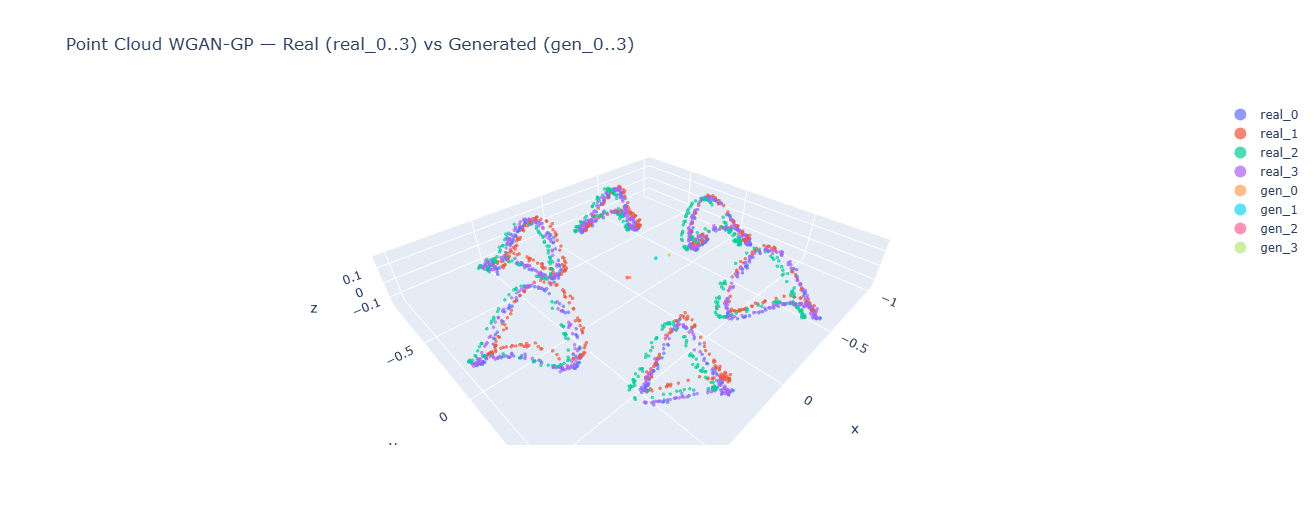

And the Isosuraface should look like...

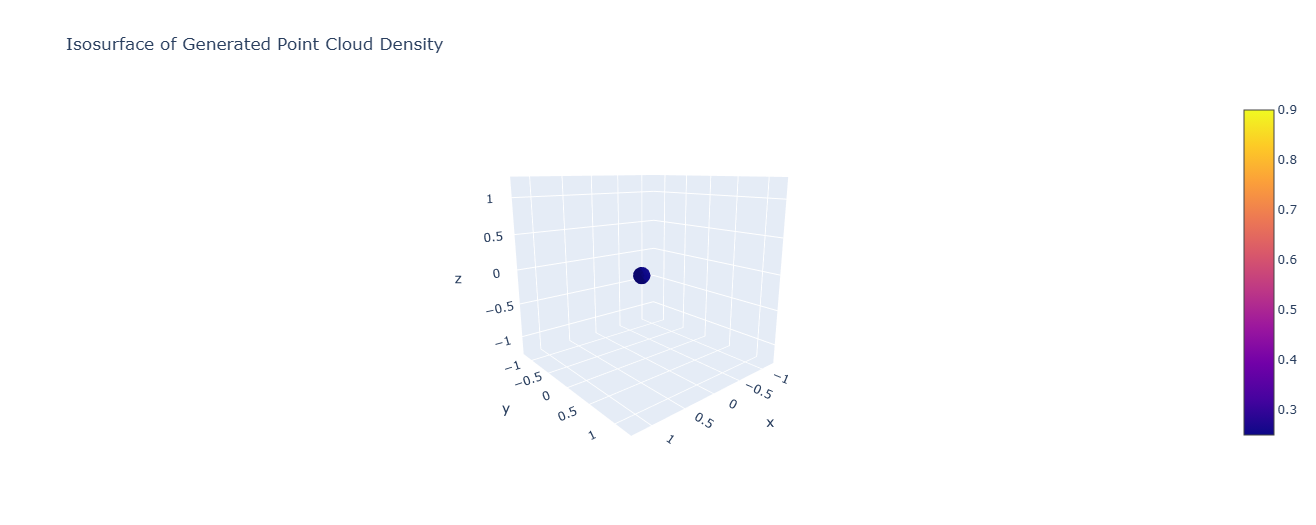

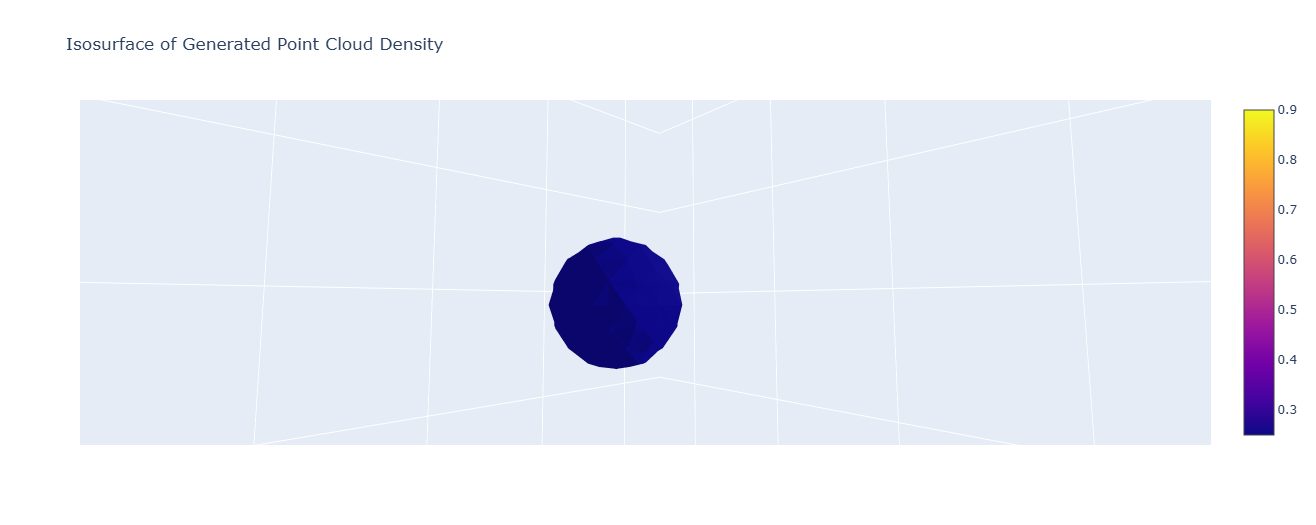

Zoom in some more and you should get...

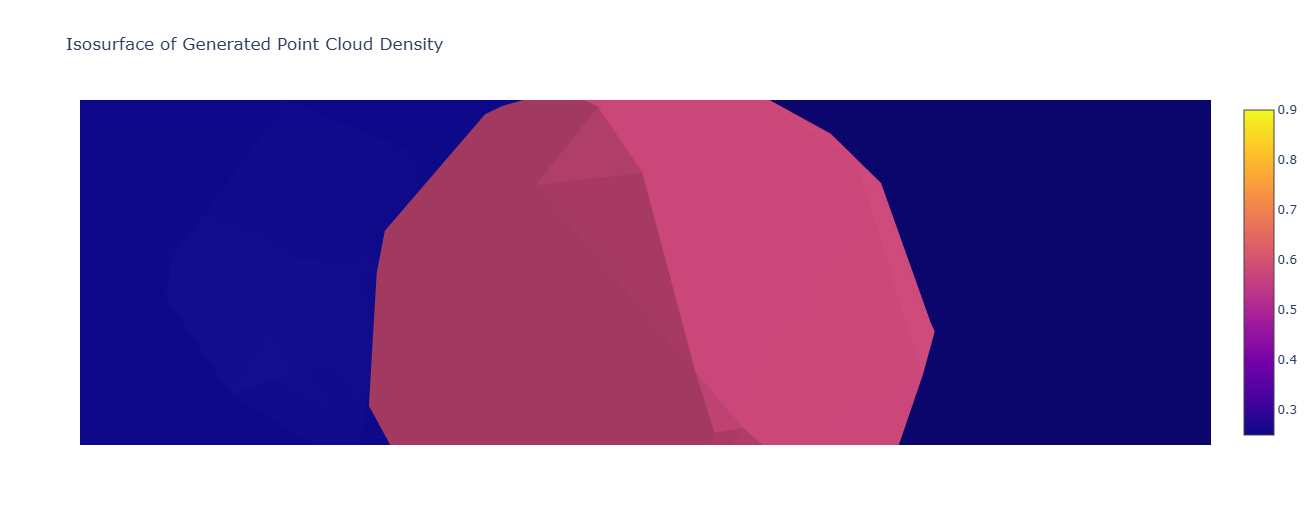

Install Packages!!!

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install numpy plotly tqdm

Imports

In [ ]:
import math, random, os
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import plotly.graph_objects as go

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # make the switch!!
print("Device:", device)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


Device: cpu


Synthetic 3D manifold sampler (low-dimensional geometry in 3D)

In [ ]:
class ManifoldMixture3D:
    def __init__(self, n_modes=6, radius=8.0, tube_sigma=0.12, scale=1.0, seed=42):
        self.n_modes = n_modes
        self.radius = radius
        self.tube_sigma = tube_sigma
        self.scale = scale
        rng = np.random.default_rng(seed)
        self.modes = []
        for i in range(n_modes):
            theta = 2 * math.pi * i / n_modes
            center = np.array([radius * math.cos(theta), radius * math.sin(theta), 0.0])
            axis = rng.normal(size=3)
            axis = axis / (np.linalg.norm(axis) + 1e-9)
            twist = rng.uniform(0.6, 2.0)
            self.modes.append((center, axis, twist))
        self.rng = rng

    def sample_point(self):
        k = self.rng.integers(0, self.n_modes)
        center, axis, twist = self.modes[k]
        t = self.rng.random() * 2*np.pi
        # Ring with vertical/phase modulation
        p = np.array([
            math.cos(t)*2.0 + 0.5*math.cos(t*twist),
            math.sin(t)*2.0 + 0.5*math.sin(t*twist),
            1.4*math.sin(2*t)
        ])
        p = p + center
        # Add small orthogonal noise to make a tube
        n = self.rng.normal(size=3)
        n = n - n.dot(axis) * axis
        n = n / (np.linalg.norm(n) + 1e-9)
        p = p + n * self.tube_sigma * self.rng.normal()
        return (p * self.scale).astype(np.float32)

    def sample_batch(self, n_points: int) -> np.ndarray:
        return np.stack([self.sample_point() for _ in range(n_points)], axis=0)  # (N,3)


class PointCloudManifoldDataset(Dataset):
    def __init__(self, n_samples=2000, points_per_cloud=512, seed=123):
        self.n_samples = n_samples
        self.points_per_cloud = points_per_cloud
        self.gen = ManifoldMixture3D(n_modes=6, radius=8.0, tube_sigma=0.12, scale=1.0, seed=seed)  # Sweetie Sweetie!!

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        pts = self.gen.sample_batch(self.points_per_cloud)  # (P,3)
        # optional global jitter
        pts += np.random.normal(scale=0.02, size=pts.shape).astype(np.float32)
        # center & scale roughly to unit-ish range (helps stability)
        pts = pts - pts.mean(0, keepdims=True)
        scale = np.max(np.linalg.norm(pts, axis=1)) + 1e-6
        pts = pts / scale
        return torch.from_numpy(pts)  # (P,3)


PointNet-style Critic and MLP Generator

In [ ]:
class SharedMLP(nn.Module):
    def __init__(self, in_ch, hidden, out_ch, act=True, ln=False):
        super().__init__()
        layers = [nn.Linear(in_ch, hidden)]
        if ln: layers.append(nn.LayerNorm(hidden))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        layers += [nn.Linear(hidden, out_ch)]
        if act:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # x: (B,P,C)
        B,P,C = x.shape
        x = x.view(B*P, C)
        x = self.net(x)
        return x.view(B, P, -1)

class PointCloudGenerator(nn.Module):
    def __init__(self, z_dim=128, points=512, width=256):
        super().__init__()
        self.points = points
        self.fc = nn.Sequential(
            nn.Linear(z_dim, width), nn.ReLU(True),
            nn.Linear(width, width), nn.ReLU(True),
        )
        # produce per-point features from a repeated global latent
        self.pt_mlp = nn.Sequential(
            nn.Linear(width, width), nn.ReLU(True),
            nn.Linear(width, 3)  # XYZ
        )

    def forward(self, z):
        # z: (B, z_dim)
        B = z.shape[0]
        g = self.fc(z)                              # (B, W)
        g = g.unsqueeze(1).expand(B, self.points, g.shape[-1])  # (B,P,W)
        pts = self.pt_mlp(g)                        # (B,P,3)
        # optional: small tanh to keep range bounded
        return torch.tanh(pts)

class PointCloudCritic(nn.Module):
    def __init__(self, width=256):
        super().__init__()
        # shared MLP on points -> global pooling -> head
        self.mlp1 = SharedMLP(3, width, width, act=True, ln=False)
        self.mlp2 = SharedMLP(width, width, width, act=True, ln=False)
        self.head = nn.Sequential(
            nn.Linear(width, width//2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(width//2, 1)
        )

    def forward(self, x):
        # x: (B,P,3)
        h = self.mlp1(x)
        h = self.mlp2(h)
        # symmetric function over points (max pooling works well)
        h = h.max(dim=1).values  # (B, width)
        s = self.head(h).squeeze(1)  # (B,)
        return s


WGAN-GP utilities & hyperparameters

In [ ]:
def gradient_penalty(critic, real_pts, fake_pts, device, lambda_gp=10.0):
    """Real/fake are (B,P,3). Interpolate in point space."""
    B = real_pts.size(0)
    alpha = torch.rand(B, 1, 1, device=device)
    interp = (alpha * real_pts + (1 - alpha) * fake_pts).requires_grad_(True)
    scores = critic(interp)
    grad = torch.autograd.grad(
        outputs=scores,
        inputs=interp,
        grad_outputs=torch.ones_like(scores),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]  # (B,P,3)
    grad = grad.view(B, -1)
    gp = ((grad.norm(2, dim=1) - 1.0) ** 2).mean() * lambda_gp
    return gp

@dataclass
class HParams:
    z_dim: int = 128
    points_per_cloud: int = 512
    batch_size: int = 32
    critic_iters: int = 5
    epochs: int = 8
    lr: float = 1e-4
    lambda_gp: float = 10.0
    gen_width: int = 256
    crit_width: int = 256

hps = HParams()


DataLoaders & model init

In [ ]:
dataset = PointCloudManifoldDataset(n_samples=2000, points_per_cloud=hps.points_per_cloud, seed=7)
loader = DataLoader(dataset, batch_size=hps.batch_size, shuffle=True, drop_last=True, num_workers=0)

gen = PointCloudGenerator(z_dim=hps.z_dim, points=hps.points_per_cloud, width=hps.gen_width).to(device)
crit = PointCloudCritic(width=hps.crit_width).to(device)

opt_g = torch.optim.Adam(gen.parameters(), lr=hps.lr, betas=(0.5, 0.9))
opt_c = torch.optim.Adam(crit.parameters(), lr=hps.lr, betas=(0.5, 0.9))

fixed_z = torch.randn(8, hps.z_dim, device=device)


Training loop (WGAN-GP)

In [ ]:
for epoch in range(hps.epochs):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{hps.epochs}")
    for real in pbar:
        real = real.to(device)  # (B,P,3)

        # Train critic several steps
        for _ in range(hps.critic_iters):
            z = torch.randn(real.size(0), hps.z_dim, device=device)
            with torch.no_grad():
                fake = gen(z)
            c_real = crit(real)
            c_fake = crit(fake)
            gp = gradient_penalty(crit, real, fake, device, lambda_gp=hps.lambda_gp)
            loss_c = -(c_real.mean() - c_fake.mean()) + gp
            opt_c.zero_grad(set_to_none=True)
            loss_c.backward()
            opt_c.step()

        # Train generator
        z = torch.randn(real.size(0), hps.z_dim, device=device)
        fake = gen(z)
        loss_g = -crit(fake).mean()
        opt_g.zero_grad(set_to_none=True)
        loss_g.backward()
        opt_g.step()

        pbar.set_postfix({'loss_c': float(loss_c.item()), 'loss_g': float(loss_g.item())}) # gpu or not, this gonna take forever!!!!!!!!!!!!!!!

    # quick generator preview per epoch
    with torch.no_grad():
        preview = gen(fixed_z).cpu().numpy()  # (8,P,3)
    last_preview = preview  # keep for plotting after loop


Epoch 8/8: 100%|██████████| 62/62 [08:48<00:00,  8.52s/it, loss_c=-3.48, loss_g=-4.27]


Plotly: real vs generated point clouds

In [ ]:
# Grab a handful of real samples
real_examples = []
for i in range(4):
    pc = dataset[i].numpy()  # (P,3)
    real_examples.append(pc)

# Use last generator preview
gen_examples = [last_preview[i] for i in range(min(4, len(last_preview)))]

def scatter3d(points, name, size=2):
    if points.size == 0:
        return go.Scatter3d(x=[0], y=[0], z=[0], mode='markers', name=name, marker=dict(size=2))
    return go.Scatter3d(
        x=points[:,0], y=points[:,1], z=points[:,2],
        mode='markers', name=name, marker=dict(size=size, opacity=0.7)
    )

fig = go.Figure()
for i, pc in enumerate(real_examples):
    fig.add_trace(scatter3d(pc, f"real_{i}", size=2))
for i, pc in enumerate(gen_examples):
    fig.add_trace(scatter3d(pc, f"gen_{i}", size=2))

fig.update_layout(
    title="Point Cloud WGAN-GP — Real (real_0..3) vs Generated (gen_0..3)",
    scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z", aspectmode="data"),
    legend=dict(itemsizing='constant')
)
fig.show()                  # yeah, didn't turn out the way I expected, this was a lot harder to build... too few generated samples.


Isosurface visualization (rasterize point clouds → density grid → isosurface)

In [ ]:
def points_to_density_grid(points: np.ndarray, grid_size=48, bbox=1.2, sigma=0.06) -> np.ndarray:
    """
    points: (N,3) in ~[-1,1] (our generator outputs tanh-bounded space)
    Returns: (D,D,D) density in [0,1]
    """
    # map to [0,1]
    pts = (points + bbox) / (2*bbox)
    pts = np.clip(pts, 0.0, 1.0)
    D = grid_size
    xs = np.linspace(0,1,D,endpoint=False) + 0.5/D
    X, Y, Z = np.meshgrid(xs, xs, xs, indexing='ij')
    grid = np.zeros((D,D,D), dtype=np.float32)
    # gaussian splat per point
    s2 = (sigma / (2*bbox))**2 + 1e-12
    for p in pts:
        dx = X - p[0]; dy = Y - p[1]; dz = Z - p[2]
        d2 = dx*dx + dy*dy + dz*dz
        grid += np.exp(-0.5 * d2 / s2)
    m = grid.max() + 1e-9
    grid = grid / m
    return grid

# choose one generated example
gen_idx = 0
gen_pc = gen_examples[gen_idx] if len(gen_examples) else dataset[0].numpy()
density = points_to_density_grid(gen_pc, grid_size=64, bbox=1.2, sigma=0.07)      # Oleku! Where's Ice Prince?!!

# Build Isosurface (pick a mid-level isovalue)
D = density.shape[0]
xs = np.linspace(-1.2, 1.2, D)
X, Y, Z = np.meshgrid(xs, xs, xs, indexing='ij')

iso = go.Isosurface(
    x=X.flatten(), y=Y.flatten(), z=Z.flatten(),
    value=density.flatten(),
    isomin=0.25, isomax=0.9,
    surface_count=3, # try a few layers
    caps=dict(x_show=False, y_show=False, z_show=False),
    showscale=True,
    name="generated_isosurface"
)

fig_iso = go.Figure(data=[iso])
fig_iso.update_layout(
    title="Isosurface of Generated Point Cloud Density",
    scene=dict(xaxis_title="x", yaxis_title="y", zaxis_title="z", aspectmode="data")
)
fig_iso.show()


Output hidden; open in https://colab.research.google.com to view.

MMD with RBF Kernel

In [ ]:
def pairwise_distances(x, y):
    """
    x: (N,D), y: (M,D)
    returns: (N,M) matrix of squared distances
    """
    x_norm = (x**2).sum(1).view(-1,1)
    y_norm = (y**2).sum(1).view(1,-1)
    dist = x_norm + y_norm - 2.0 * x @ y.t()
    return dist

def compute_mmd(x, y, sigma=0.5):
    """
    MMD with RBF kernel between sets of vectors
    x: (N,D), y: (M,D)
    """
    dist_xx = pairwise_distances(x, x)
    dist_yy = pairwise_distances(y, y)
    dist_xy = pairwise_distances(x, y)

    k_xx = torch.exp(-dist_xx / (2*sigma**2))
    k_yy = torch.exp(-dist_yy / (2*sigma**2))
    k_xy = torch.exp(-dist_xy / (2*sigma**2))

    mmd = k_xx.mean() + k_yy.mean() - 2*k_xy.mean()
    return mmd.item()


Chamfer Distance

In [ ]:
def chamfer_distance(pc1, pc2):
    """
    pc1: (N,3), pc2: (M,3)
    """
    diff1 = torch.cdist(pc1, pc2)  # (N,M)
    min1 = diff1.min(1).values
    min2 = diff1.min(0).values
    cd = min1.mean() + min2.mean()
    return cd.item()


Evaluation function

In [ ]:
def evaluate_generator(gen, dataset, n_eval=100, z_dim=128, device='cpu'):
    gen.eval()
    real_clouds, fake_clouds = [], []
    with torch.no_grad():
        for i in range(n_eval):
            # real
            real = dataset[i].to(device)  # (P,3)
            real_clouds.append(real)
            # fake
            z = torch.randn(1, z_dim, device=device)
            fake = gen(z).squeeze(0)
            fake_clouds.append(fake)

    # Flatten all points across clouds for MMD
    real_concat = torch.cat(real_clouds, dim=0)  # (n_eval*P,3)
    fake_concat = torch.cat(fake_clouds, dim=0)

    mmd_val = compute_mmd(real_concat, fake_concat, sigma=0.5)

    # Chamfer: average across matched pairs
    cds = []
    for r, f in zip(real_clouds, fake_clouds):
        cds.append(chamfer_distance(r, f))
    cd_val = np.mean(cds)

    return {"MMD": mmd_val, "Chamfer": cd_val}
